# Behavioural validation of the extreme PCA

Run the MVET_IDP_PCA.ipynb first to find the extreme principal components (PCs).
In this script we are going to look at the correlation between the first two extreme PCs and several behavioural measures from the UKB.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics
#sns.set(style='whitegrid')
sns.set(style='ticks', palette='Set2')
sns.despine()

<Figure size 432x288 with 0 Axes>

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = "sans-serif"
rcParams['font.sans-serif'] = "Arial"

In [3]:
# For using R within python
%load_ext rpy2.ipython

In [4]:
%%R
R.version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          1.0                         
year           2021                        
month          05                          
day            18                          
svn rev        80317                       
language       R                           
version.string R version 4.1.0 (2021-05-18)
nickname       Camp Pontanezen             


In [5]:
def retrieve_UKBB_covariates(csv_file_path, fields_code_list, fileds_name_list, 
                             save_path = None, drop_nans = True):
    '''
    Example:
        csv_file_path = '/project_freenas/3022017.02/UKB/phenotypes/ukb35187.csv'
        save_path =  '/project_freenas/3022017.02/UKB/phenotypes/test.csv'
        fields_code_list = ['21003-2.0', '31-0.0', '54-2.0']
        fileds_name_list = ['age', 'gender', 'site_id']
        
        covariates, subs = retrieve_UKBB_covariates(csv_file_path, fields_code_list, 
                                          fileds_name_list, save_path)
    '''
    
    ukbb_covariates = pd.read_csv(csv_file_path, encoding= 'unicode_escape', 
                                   usecols=['eid'] + fields_code_list)
    if drop_nans:
        ukbb_covariates = ukbb_covariates.dropna()
    ukbb_subs = list(ukbb_covariates['eid'])
    ukbb_subs = [str(u) for u in ukbb_subs]
    ukbb_covariates['eid'] = ukbb_subs
    ukbb_covariates = ukbb_covariates.set_index('eid')
    c = dict()
    for i, code in enumerate(fields_code_list):
        c[code] = fileds_name_list[i]
    ukbb_covariates = ukbb_covariates.rename(columns=c)
    if save_path is not None:
        ukbb_covariates.to_csv(save_path)
    return ukbb_covariates, ukbb_subs

# Fluid intelligence
First we will look with a bit more detail at fluid intelligence, as this is usually used to validate a new method.

In [6]:
# Remove num memory, for very few participants and pros mem, as categorical
# https://biobank.ctsu.ox.ac.uk/crystal/label.cgi?id=100026
cp_code_list = [#'4282-2.0', # Numeric memory
                '20016-2.0', # Reasoning/fluid int
                #'20023-2.0', # Reaction time
                #'399-2.2', # Visual memory, pair matching
                #'21004-2.0', # tower_rearranging, number puzzles correct
                #'6348-2.0', # duration trail n
                #'6350-2.0', # duration trail a
                #'6373-2.0', # matrix pattern puzzles solved
                #'23324-2.0' # digits matched correctly
               ] #  399 had 3 pair and 6 pair
cp_name_list = [#'Numeric_memory',
                'Fluid_intelligence', 
                #'Reaction_time', 
                #'Visual_memory', 
                #'tower_rearranging', 
                #'trail_making_n', 
                #'trail_making_a',
                #'matrix_pattern_completion', 
                #'symbol_digit_substitution'
               ] #'numeric_memory'
CPs, subs = retrieve_UKBB_covariates('/project_freenas/3022017.02/UKB/phenotypes/current/32_cognitive_phenotypes.csv', cp_code_list, cp_name_list)

## Preprocess the behavioural data
1. To make the data more Gaussian transfer some to log space
2. Normalize before PCA, as PCA tries to maximize the variance, and otherwise the largest component will explain the most variance. 

In [7]:
#CPs['Reaction_time'] = np.log(CPs['Reaction_time'])
#CPs['Visual_memory'] = np.log(CPs['Visual_memory']+1)
scaler = MinMaxScaler()
CPs_scaled = scaler.fit_transform(CPs)
CPs_scaled_df = pd.DataFrame(data = CPs_scaled, columns = CPs.columns)
CPs_scaled_df.describe()
CPs_scaled_df.index = list(map(int,subs))

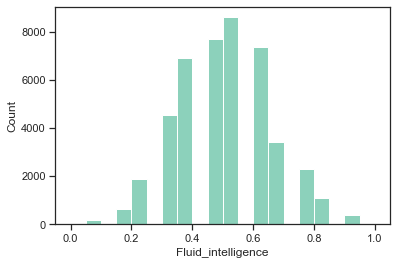

In [8]:
for cp in cp_name_list:
    plt.figure()
    sns.histplot(data=CPs_scaled_df[cp], bins = 20)

## Select standard PC or extreme PC
Select the participants that have both the PCs (brain data) and the CPs data available. 
Select if you want the standard space PCs (PCs_ss.csv) or the extreme PCs (PCs.csv)

In [9]:
Z_df = pd.read_csv('/project_cephfs/3022017.02/projects/big_data/data/ukb_processed_4/deviation_scores.csv', index_col=0)
standard = False #else extreme
if standard:
    PCs_df = pd.read_csv('/home/preclineu/chafra/Desktop/code_phd/data/data/PCs_ss.csv')
    ending = 'standard'
else:
    PCs_df = pd.read_csv('/home/preclineu/chafra/Desktop/code_phd/data/data/PCs.csv')
    ending = 'extreme'

PCs_df.index = Z_df.index

In [10]:
PCs_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V384,V385,V386,V387,V388,V389,V390,V391,V392,V393
1000050,86.994163,38.498381,73.123153,-11.500330,30.392452,3.631413,0.614344,-4.061997,-19.912635,21.046763,...,-2.215134,5.130689,1.292219,9.197892,-1.066490,7.916962,-22.161738,-19.430733,-2.796399,11.421446
1000853,106.144236,-1.363695,-27.062466,24.143379,-3.776393,2.558739,-37.028131,5.749793,-27.479021,-9.290879,...,-6.520748,0.642518,-5.575715,1.909172,-4.445183,3.533695,-0.028182,-4.184352,4.741820,-0.488907
1000871,81.864481,-10.013025,17.115748,10.754801,-22.780475,12.702933,6.353028,-10.204902,2.304078,0.960591,...,-2.040270,-0.212214,2.823172,-2.467136,2.700997,-1.197074,0.310953,-0.607371,0.433213,-2.482819
1000910,61.854943,22.381437,8.724620,12.215135,-18.013473,8.537698,-4.770014,-8.394322,0.113616,9.268451,...,0.668695,1.432116,0.742016,0.512428,0.658466,1.006393,-4.249317,1.587711,-0.173519,-2.856895
1001018,80.850709,21.738006,-3.234381,-11.000345,-6.554109,2.715896,2.644736,16.141851,-1.911254,-0.842084,...,-0.097889,1.209261,0.287679,-2.873449,0.329531,0.310581,-1.216044,1.469529,-1.918750,-3.465681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6024836,130.743857,-16.066218,-7.142564,3.133672,-2.187618,19.230082,-73.873481,51.423209,-6.904807,15.857640,...,-1.130019,5.476280,0.118161,5.426165,7.440474,0.648511,11.110365,-2.238185,8.953087,-4.377468
6024902,58.378855,14.505128,9.784930,-0.483314,-2.645152,-2.003598,0.125616,-2.533637,-4.342409,6.044179,...,0.016644,1.271891,-1.117546,0.492338,-0.391073,-1.178878,1.933224,-0.186764,-0.294333,0.069879
6025056,52.733247,10.385999,7.747413,4.243478,-9.974634,8.229156,-6.760632,-0.487845,-0.726368,7.088278,...,0.823671,2.732546,0.462399,-0.625203,0.953480,1.666283,0.094442,0.987678,1.022515,-1.727680
6025069,64.580126,20.819205,13.048209,1.004554,0.726798,3.905585,-4.956436,-3.135654,1.429722,3.467837,...,-0.496919,0.984032,-1.463900,-0.587261,-0.277163,-1.856823,3.286193,0.208468,0.253441,-0.626418


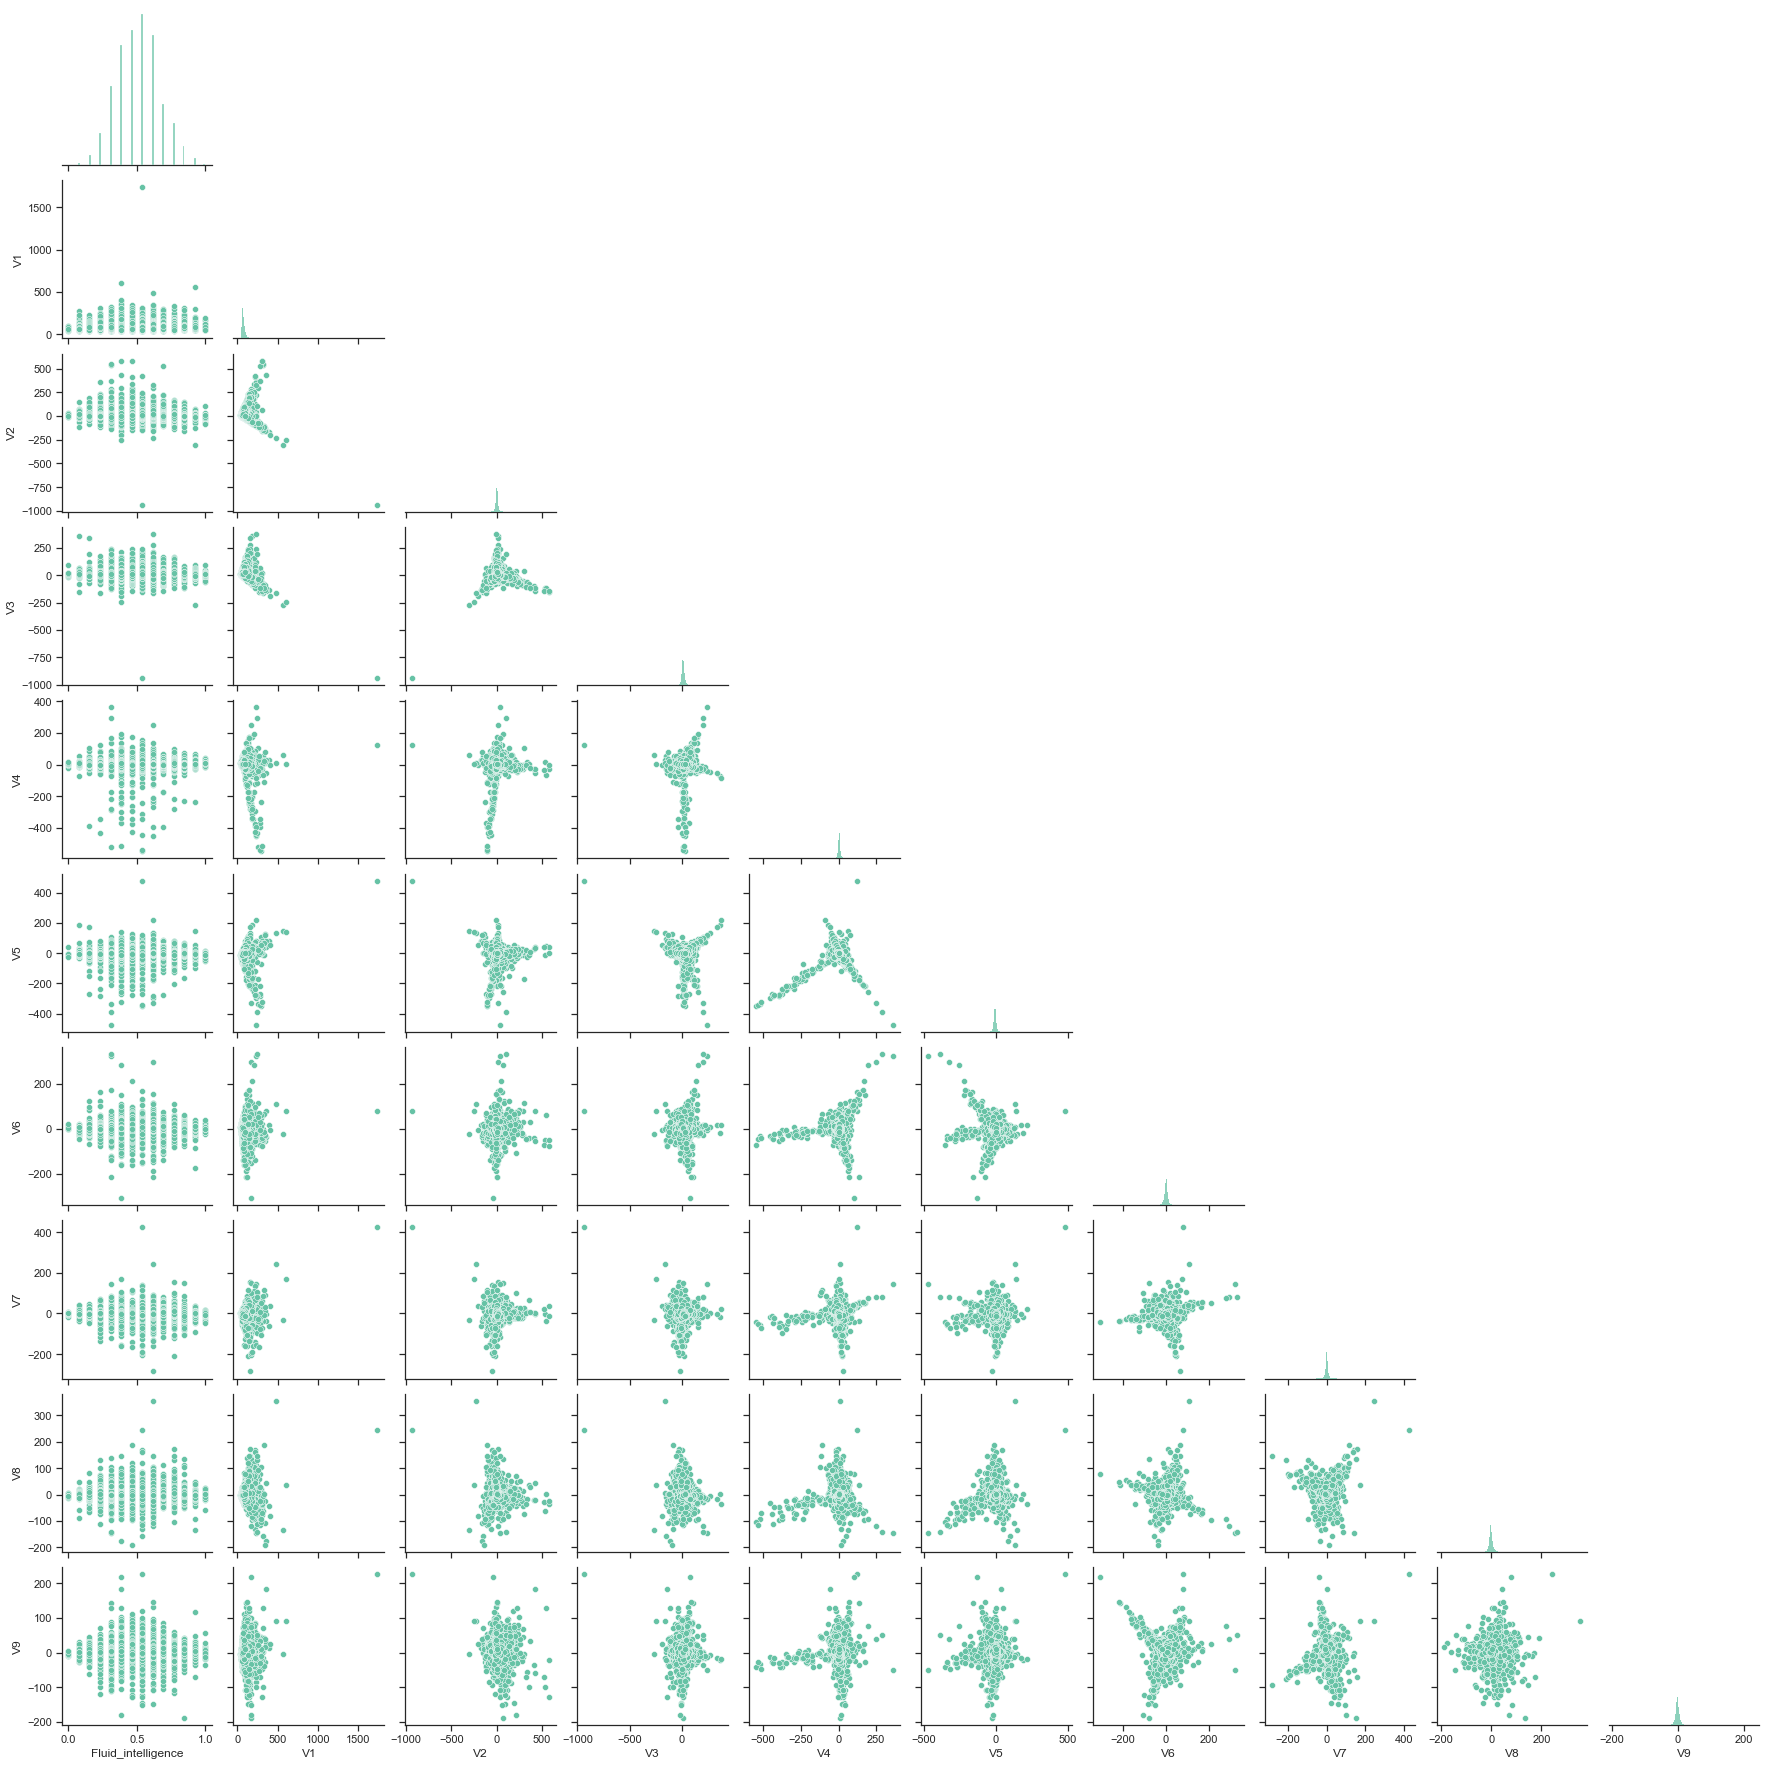

In [11]:
CPs_scaled_df_dep = CPs_scaled_df.loc[CPs_scaled_df.index.intersection(PCs_df.index)]
PCs_df_dep = pd.DataFrame(PCs_df.loc[CPs_scaled_df.index.intersection(PCs_df.index)])
CPs_PCs_df = pd.concat([CPs_scaled_df_dep, PCs_df_dep], axis=1)

sns.pairplot(data = CPs_PCs_df.iloc[:,0:10], corner=True)

## Correlation PC and fluid intelligence 

In [12]:
rho = np.zeros(np.shape(PCs_df_dep)[1])
p = np.zeros(np.shape(PCs_df_dep)[1])
for i in range(np.shape(PCs_df_dep)[1]):
    print(i)
    rho[i], p[i] = stats.spearmanr(CPs_scaled_df_dep, PCs_df_dep.iloc[:,i])
    print('stat:', rho[i], 'pval:', p[i])

0
stat: 0.13095638610482077 pval: 8.007139256985448e-138
1
stat: -0.1334305437665665 pval: 4.746679786048752e-143
2
stat: -0.06486395181086292 pval: 5.720827844618496e-35
3
stat: -0.04650091379082403 pval: 9.58093147521486e-19
4
stat: 0.0176219581936 pval: 0.0008127701370821507
5
stat: 0.0011962491788231038 pval: 0.8202014742769654
6
stat: 0.027537628255057546 pval: 1.6668558168013718e-07
7
stat: 0.019880277450689977 pval: 0.00015834702576401116
8
stat: 0.01698586103782861 pval: 0.0012486653591507087
9
stat: -0.02879566680060101 pval: 4.4429850671092624e-08
10
stat: 0.037960231396448996 pval: 5.393624320567536e-13
11
stat: -0.016072877459233317 pval: 0.002257949000032328
12
stat: 0.007454182738809816 pval: 0.15668634547360716
13
stat: 0.026888961725159102 pval: 3.225151112557738e-07
14
stat: 0.00627008542472996 pval: 0.23352810713054015
15
stat: -0.009350794112309328 pval: 0.07562133017258481
16
stat: -0.03085185676556294 pval: 4.540094920510714e-09
17
stat: -0.025155511954256842 pval:

stat: -0.0012730896901976248 pval: 0.808868913758019
160
stat: 0.004901476897022941 pval: 0.3517088716953486
161
stat: 0.0009805590486990203 pval: 0.8522056071978605
162
stat: -0.00882303941453903 pval: 0.09366016145108381
163
stat: 0.03161392595557155 pval: 1.8770315729292883e-09
164
stat: 0.007502404189733968 pval: 0.1540222574891246
165
stat: -0.016769460207619095 pval: 0.0014405557223145472
166
stat: 0.0017273900391582555 pval: 0.7427588757192272
167
stat: 0.0036259287856264598 pval: 0.4908711188540118
168
stat: -0.014991908942271715 pval: 0.004391163072122513
169
stat: -0.02097948876588709 pval: 6.705118061526206e-05
170
stat: 0.021332602964850043 pval: 5.0429443033569515e-05
171
stat: 0.003479078835617771 pval: 0.508597947623697
172
stat: 0.016845928208717702 pval: 0.0013698418475976508
173
stat: 0.00890326636808406 pval: 0.09071417331999126
174
stat: 0.009432625640215643 pval: 0.07309671907335316
175
stat: -0.004047497467457826 pval: 0.44188004694197425
176
stat: 0.0006129669073

stat: 0.028563374289753286 pval: 5.69536325839928e-08
302
stat: 0.0015456329061858153 pval: 0.7690113079544261
303
stat: -0.011821356808585997 pval: 0.024696276937716567
304
stat: -3.245697925783683e-05 pval: 0.9950796499580565
305
stat: -0.004989291009231456 pval: 0.3431474626146509
306
stat: -0.023738776271054234 pval: 6.453127635367835e-06
307
stat: -0.00252159836653334 pval: 0.631866683515351
308
stat: -0.021135978248659325 pval: 5.912985762965144e-05
309
stat: 0.016771778202967883 pval: 0.0014383636066402066
310
stat: -0.0018381150729067741 pval: 0.7269093337528495
311
stat: -0.022641300023686625 pval: 1.689818283554675e-05
312
stat: 0.018850463902269656 pval: 0.00034112844047366655
313
stat: 0.006228025684010722 pval: 0.23667911653952847
314
stat: 0.010694410710513998 pval: 0.04215547162395902
315
stat: 0.005159888861685912 pval: 0.3268992593135386
316
stat: 0.008306236279546362 pval: 0.11451939789934529
317
stat: 0.000754921204301911 pval: 0.8859473882844793
318
stat: 0.03021663

In [13]:
p_df = pd.DataFrame(p, columns=['pvalue'])
p_df = p_df.reset_index()

No handles with labels found to put in legend.


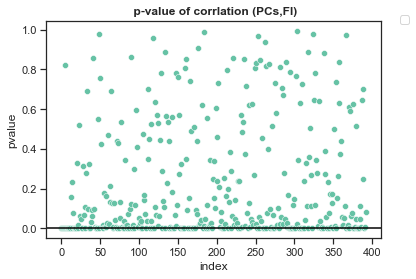

In [14]:
fig=sns.scatterplot(data=p_df, x='index',y='pvalue')
fig.axhline(.05/len(p_df),color='k')
plt.legend(bbox_to_anchor=(1.1,1.05))
plt.title(' p-value of corrlation (PCs,FI)',fontweight="bold")
plt.show()
plt.close()

In [15]:
print(f'PCs, Number of correlations passing p-value: {sum(p_df.iloc[:,1]<.05/len(p_df))}')

PCs, Number of correlations passing p-value: 62


# Correlation non-IDPs

Correlate the first two extreme PCs to different non IDP values, using a standard spearmanr correlation. The spearmanr correlation does not assume that both distributions are normally distributed. 

Code based on this amazing paper: 
- Non-linearity matters: a deep learning solution to generalization of hidden brain patterns across population cohorts Mariam Zabihi.

In [16]:
PCs=PCs_df.iloc[:,0:3]
nIDP_df=pd.read_csv('/project_cephfs/3022017.02/projects/big_data/data/nIDPs.csv',index_col=0)
data_dictionary=pd.read_csv('/home/preclineu/chafra/Desktop/code_phd/EVT/data_dictionary.csv',index_col=0)

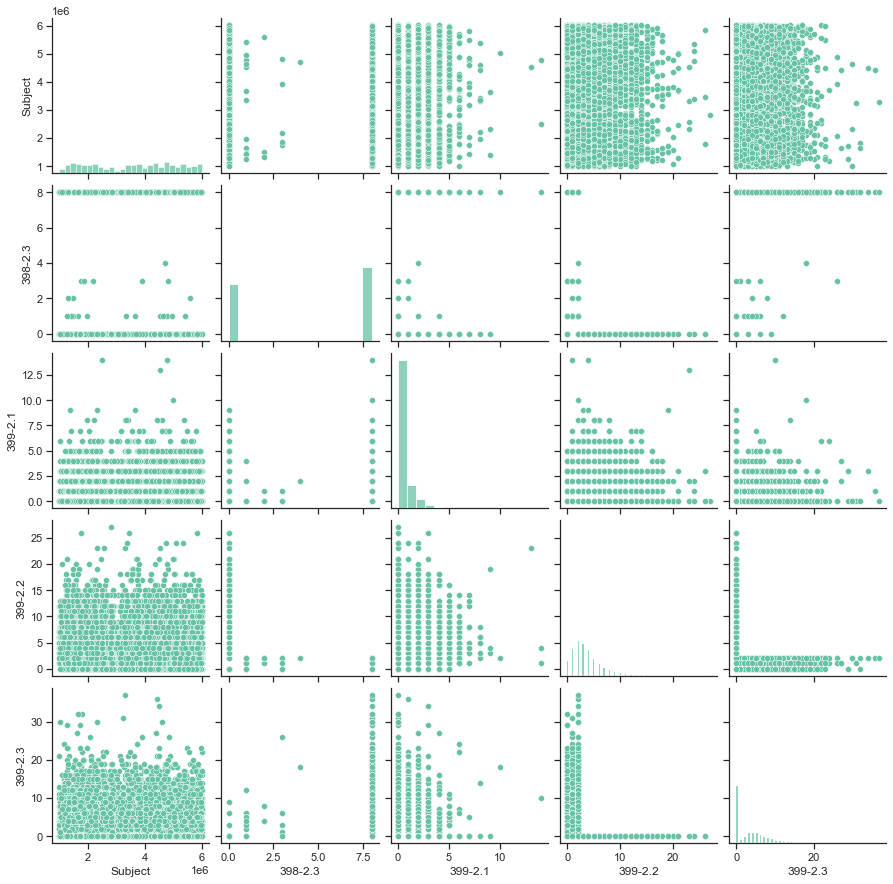

In [17]:
nIDP_df
sns.pairplot(nIDP_df.iloc[:,0:5])

In [18]:
nIDP_df = nIDP_df.set_index('Subject')
nIDP_df.head()

,398-2.3,399-2.1,399-2.2,399-2.3,400-2.1,400-2.2,401-2.0,401-2.1,401-2.2,401-2.3,...,4537-2.0,4548-2.0,4559-2.0,4570-2.0,4581-2.0,4598-2.0,4631-2.0,4653-2.0,54-2.0,21003-2.0
Subject,,,,,,,,,,,,,,,,,,,,,
2909865,NaN,1.0,4.0,NaN,83.0,267.0,3.0,2.0,7.0,2.0,...,2.0,2.0,2.0,2.0,3.0,0.0,0.0,0.0,11025.0,62.0
5580304,0.0,1.0,4.0,0.0,179.0,395.0,9.0,2.0,9.0,0.0,...,7.0,3.0,1.0,2.0,3.0,1.0,1.0,1.0,11025.0,66.0
2559492,8.0,0.0,1.0,4.0,70.0,173.0,5.0,4.0,0.0,4.0,...,3.0,4.0,3.0,3.0,3.0,1.0,1.0,0.0,11025.0,51.0
2499418,NaN,0.0,3.0,NaN,65.0,295.0,9.0,2.0,6.0,4.0,...,2.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,11025.0,56.0
4195994,NaN,0.0,3.0,NaN,90.0,238.0,7.0,8.0,7.0,8.0,...,3.0,2.0,1.0,1.0,3.0,0.0,0.0,0.0,11027.0,61.0


In [19]:
X = PCs.join(nIDP_df)
P = pd.DataFrame()
for nIDP in nIDP_df: 
    df=X[['V1','V2', 'V3' ,nIDP]]
    df = df.dropna()
    r,p=spearmanr(df[['V1','V2', 'V3']],df[nIDP])
    pvalue=pd.DataFrame(columns=['FieldID-instance'],data=[nIDP])
    pvalue[['PC1','PC2', 'PC3']]=[-np.log10(p[3,:3])]
    P=pd.concat([P,pvalue])
    
Pvalue=pd.merge(data_dictionary[['FieldID-instance','nIDP_category','Field']],P,how='inner',on='FieldID-instance')
Pvalue=Pvalue.reset_index()
Pvalue=Pvalue.rename(columns={'index':'nIDPs'})
Pvalue=Pvalue.drop(Pvalue[Pvalue['nIDP_category']=='age_sex_site'].index)
Pvalue.head()

,nIDPs,FieldID-instance,nIDP_category,Field,PC1,PC2,PC3
0,0,398-2.3,cognitive_phenotypes,Number of correct matches in round,1.918929,3.232703,1.791745
1,1,399-2.1,cognitive_phenotypes,Number of incorrect matches in round,6.206532,12.726487,1.302025
2,2,399-2.2,cognitive_phenotypes,Number of incorrect matches in round,0.624482,6.459442,1.326166
3,3,399-2.3,cognitive_phenotypes,Number of incorrect matches in round,1.424808,0.996714,0.762406
4,4,400-2.1,cognitive_phenotypes,Time to complete round,3.525510,19.627179,2.673691


Manhattan plot of the p-values for the univariate correlation of non-imaging measures with the first two extreme PCAs and the standard PCAs. The black line shows the Bonferonni-corrected p-value threshold.
We use the log10 scale, so we have to look at values that pass the black line.

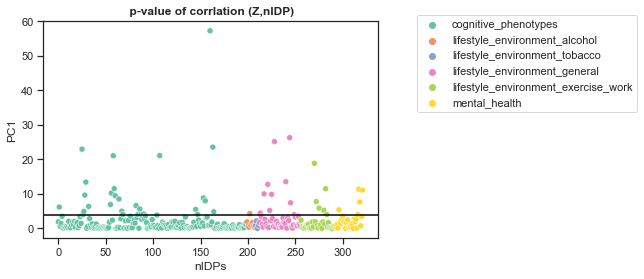

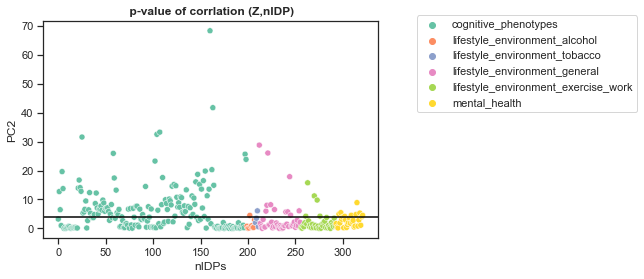

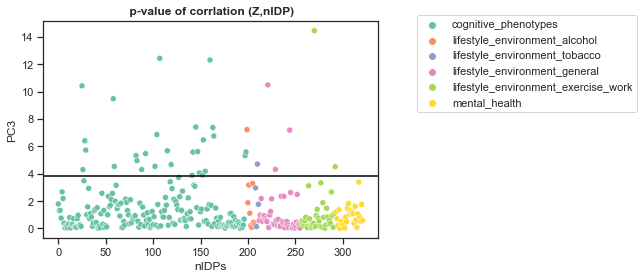

In [20]:
for idp in ['PC1','PC2', 'PC3']:
    fig=sns.scatterplot(data=Pvalue, x='nIDPs',y=idp, hue='nIDP_category')
    fig.axhline(-np.log10(.05/len(P)),color='k')

    plt.legend(bbox_to_anchor=(1.1,1.05))
    plt.title(' p-value of corrlation (Z,nIDP)', fontweight="bold")
    #plt.savefig(nm_dir+idp+'.png',dpi=300,bbox_inches='tight')
    plt.show()
    plt.close()

In [21]:
print(f'PCA1, Number of correlations passing p-value: {np.sum(P.iloc[:,1]>-np.log10(.05/len(P)))}')
print(f'PCA2, Number of correlations passing p-value: {np.sum(P.iloc[:,2]>-np.log10(.05/len(P)))}')
print(f'PCA3, Number of correlations passing p-value: {np.sum(P.iloc[:,3]>-np.log10(.05/len(P)))}')

PCA1, Number of correlations passing p-value: 52
PCA2, Number of correlations passing p-value: 134
PCA3, Number of correlations passing p-value: 37


## Correlation diagnosis and extreme PCAs
The IDP codes can be found here:
https://biobank.ndph.ox.ac.uk/showcase/coding.cgi?id=6
We will look at two diagnosis that we expect to have extreme values:
chronic/degenerative neurological problem:
- motor neurone disease (69) - 1259
- myasthenia gravis (59) - 1260
- multiple sclerosis (1995) - 1261
- parkinsons disease (1011) - 1262
- dementia/alzheimers/cognitive impairment (154) - 1263
- other demyelinating disease (not multiple sclerosis) (81) - 1397

In [22]:
df = pd.read_csv("/project_freenas/3022017.02/UKB/phenotypes/current/50_health_outcomes_headers.csv")
diagnosis_ids = [col for col in df if col.startswith('20002')]
diagnosis_ids.append('eid')
diagnosis_df = pd.read_csv("/project_freenas/3022017.02/UKB/phenotypes/current/50_health_outcomes.csv", usecols = diagnosis_ids)
diagnosis_df = diagnosis_df.set_index('eid')

In [23]:
degenerative_df = diagnosis_df[['20002-0.1259', '20002-0.1260', '20002-0.1261', '20002-0.1262', '20002-0.1263', '20002-0.1397']]
print(f'Number of subject with a neurological problem: \n{degenerative_df.sum()}')

Number of subject with a neurological problem: 
20002-0.1259      65
20002-0.1260      58
20002-0.1261    1831
20002-0.1262     948
20002-0.1263     152
20002-0.1397      80
dtype: int64


We want to correlate a continious variable with a binary variable, so we have to use the Point-Biserial Correlation

In [24]:
# Select only participants that also have brain data
degenerative_df = degenerative_df.loc[degenerative_df.index.intersection(PCs_df.index)]
PCs_df_dep = PCs_df.loc[degenerative_df.index]
print(f'Number of subject with a neurological problems and brain data: {degenerative_df.sum().sum()}')

Number of subject with a neurological problems and brain data: 234


In [25]:
PCs=PCs_df.iloc[:,0:3]
X = PCs.join(degenerative_df)
P = pd.DataFrame()
for nIDP in degenerative_df: 
    df=X[['V1','V2', 'V3',nIDP]]
    df = df.dropna()
    r1, p1 = stats.pointbiserialr(df['V1'],df[nIDP])
    r2, p2 = stats.pointbiserialr(df['V2'],df[nIDP])
    r3, p3 = stats.pointbiserialr(df['V3'],df[nIDP])
    pvalue=pd.DataFrame(columns=['FieldID-instance'],data=[nIDP])
    pvalue['PC1'] = -np.log10(p1)
    pvalue['PC2'] = -np.log10(p2)
    pvalue['PC3'] = -np.log10(p3)
    P=pd.concat([P,pvalue])    

In [26]:
P['nIDP_category'] = 'neurodegenerative_disorders'
P['Field'] = ['motor neurone disease', 'myasthenia gravis', 'multiple sclerosis', 'parkinsons disease', 'dementia/alzheimers/cognitive-impairment', 'other demyelinating disease']


In [27]:
Pvalue_all = pd.concat([P, Pvalue.drop('nIDPs', axis=1)])
Pvalue_all = Pvalue_all.reset_index(drop=True).reset_index()
Pvalue_all=Pvalue_all.rename(columns={'index':'nIDPs'})


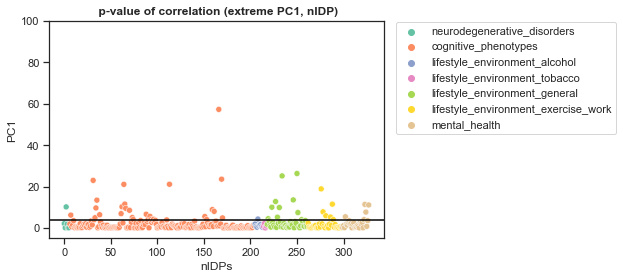

In [28]:
plt.figure()
fig=sns.scatterplot(data=Pvalue_all, x='nIDPs',y='PC1', hue='nIDP_category')
fig.axhline(-np.log10(.05/len(Pvalue_all)),color='k')

plt.legend(bbox_to_anchor=(1.02,1.02))
plt.title(f' p-value of correlation ({ending} PC1, nIDP)', fontweight="bold")
plt.ylim([-5,100])
plt.show()
plt.close()

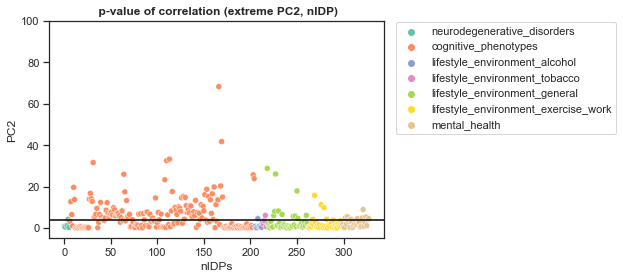

In [29]:
plt.figure()
fig=sns.scatterplot(data=Pvalue_all, x='nIDPs',y='PC2', hue='nIDP_category')
fig.axhline(-np.log10(.05/len(Pvalue_all)),color='k')

plt.legend(bbox_to_anchor=(1.02,1.02))
plt.title(f' p-value of correlation ({ending} PC2, nIDP)', fontweight="bold")
#plt.savefig(nm_dir+idp+'.png',dpi=300,bbox_inches='tight')
plt.ylim([-5,100])
plt.show()
plt.close()

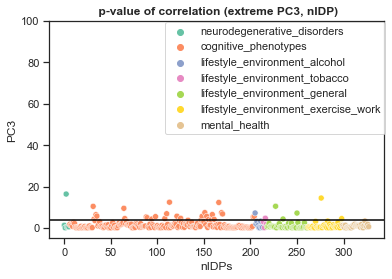

In [30]:
plt.figure()
fig=sns.scatterplot(data=Pvalue_all, x='nIDPs',y='PC3', hue='nIDP_category')
fig.axhline(-np.log10(.05/len(Pvalue_all)),color='k')

plt.legend(bbox_to_anchor=(1.02,1.02))
plt.title(f' p-value of correlation ({ending} PC3, nIDP)', fontweight="bold")
#plt.savefig(nm_dir+idp+'.png',dpi=300,bbox_inches='tight')
plt.ylim([-5,100])
plt.show()
plt.close()

In [31]:
print(f'PC1, Number of correlations passing p-value: {np.sum(Pvalue_all.iloc[:,2]>-np.log10(.05/len(Pvalue_all)))}')
print(f'PC2, Number of correlations passing p-value: {np.sum(Pvalue_all.iloc[:,3]>-np.log10(.05/len(Pvalue_all)))}')
print(f'PC3, Number of correlations passing p-value: {np.sum(Pvalue_all.iloc[:,4]>-np.log10(.05/len(Pvalue_all)))}')

PC1, Number of correlations passing p-value: 52
PC2, Number of correlations passing p-value: 135
PC3, Number of correlations passing p-value: 36
